## Extracting features and target

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
fin_lines = pd.read_csv(r'df_40_authors_all_features_0003percent.csv')

In [3]:
fin_lines.drop(columns = ['book_line', 'Unnamed: 0'], inplace = True)
fin_lines.reset_index(drop = True, inplace = True)

In [4]:
fin_lines

,book_author,len_line,neg,neu,pos,compound,objectivity,pos_vs_neg,ADJ,ADV,...,year old,yellow,yesterday,yield,youll,young,young man,young woman,youth,youv
0,Grant Allen,307,0.058,0.908,0.034,-0.3400,0.908,-0.024,5,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Grant Allen,434,0.231,0.669,0.100,-0.9233,0.669,-0.131,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grant Allen,303,0.051,0.949,0.000,-0.4588,0.949,-0.051,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Grant Allen,317,0.039,0.926,0.035,-0.0550,0.926,-0.004,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Grant Allen,499,0.000,0.896,0.104,0.8387,0.896,0.104,6,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,Max Allan Collins,494,0.000,0.980,0.020,0.1779,0.980,0.020,9,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3196,Max Allan Collins,560,0.056,0.895,0.049,-0.2023,0.895,-0.007,3,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3197,Max Allan Collins,360,0.100,0.751,0.149,0.3476,0.751,0.049,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3198,Max Allan Collins,343,0.052,0.683,0.265,0.9195,0.683,0.213,7,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
fin_lines.shape

(3200, 2172)

The dataset I have collected contains all the chosen paragraphes by all 40 authors. In order to compare the effect of increase in number of classes on prediction accuracy, I have sliced this DataFrame into 10 new datasets with the number of authors from 2 to 10.

The code for crteating this datasets is represented below, further I will use the DataFrames prepared beforehand.

In [6]:
list_of_masks = []

for num in range(10,11):
    author_list = fin_lines.book_author.unique()[:num]
    mask = '('
    for author in author_list:
        condition = "(book_author == '{}')".format(author)
        if author != author_list[-1]:
            mask += condition 
            mask += '|'
        else:
            mask +=  condition +  ')'
    list_of_masks.append(mask)

In [7]:
list_of_paths = []

for mask in list_of_masks:
    new_df = fin_lines.query(mask)
    file_path = "Comparison/df_authors_{}.csv".format(len(new_df.book_author.unique()))
    new_df.to_csv(file_path, columns = fin_lines.columns)
    list_of_paths.append(file_path)

In [8]:
# As the result of slicing, I came up with 10 following files:

list_of_paths

['Comparison/df_authors_10.csv']

In [9]:
scaler = StandardScaler()

GridSearch for the best parameters of each model

In [10]:
comparison_grid = pd.DataFrame()
comparison_grid['model'] = ['LR', 'RFC', 'SVM', 'GBC', 'KNN', 'Perceptron', 'MLP']

In [ ]:
for path in list_of_paths:
    df = pd.read_csv(path)
    df.drop(columns = ['Unnamed: 0'], inplace = True)
    df.reset_index(drop = True, inplace = True)
    num_authors = len(df.book_author.unique())
    print(f"num_authors={num_authors}, path={path}")
    # Select target and predictors and split the data into training and testing sets
    y = df.pop('book_author')
    X = df
    print("Splitting...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # Standardise the data
    print("Scaling...")
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    # First model - Logistical Regression + GridSearch
    LR = LogisticRegression()
    LR_gs_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                     'C':[0.001,.009,0.01,.09,1,5,10,25],
                    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
                   }
    print("GridSearching LR...")
    LR_grid = GridSearchCV(LR, param_grid = LR_gs_params, n_jobs=-1, cv=3, scoring = 'accuracy')
    LR_grid.fit(X_train, y_train)
    print('LR done')
    # Second model - Random Forest Classifier
    RFC = RandomForestClassifier()
    RFC_gs_params = {'n_estimators': [30, 50, 100, 200, 300],
                     'criterion': ['gini', 'mse', 'mae'],
                     'max_depth': [10,15,25,30,50, 75,100],
                     'random_state':[42]
                    }
    print("GridSearching RFC...")
    RFC_grid = GridSearchCV(RFC, param_grid = RFC_gs_params, n_jobs=-1, cv=3, scoring = 'accuracy')
    RFC_grid.fit(X_train, y_train)
    print('RFC done')
    # Third model - Support Vector Classificator
    svm_cl = svm.SVC()
    svm_params = {'C': [0.1,1, 10, 100], 
                      'gamma': [0.1, 1, 10, 50, 100],
                      'kernel': ['rbf', 'sigmoid'],
                      'decision_function_shape': ['ovo', 'ovr']
                     }
    print("GridSearching SVM...")
    svm_grid = GridSearchCV(svm_cl, param_grid = svm_params, n_jobs=-1, cv=3, scoring = 'accuracy')
    svm_grid.fit(X_train, y_train)
    print('SVM done')
    # Fourth model - GradientBoostingClassifier
    gb_model = GradientBoostingClassifier()
    gb_params = {'loss': ['deviance', 'exponential'],
                 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                 'n_estimators': [10, 25, 50, 100, 200],
                 'criterion': ['friedman_mse', 'mse', 'mae', 'gini']
                 }
    print("GridSearching GB...")
    gb_grid = GridSearchCV(gb_model, param_grid = gb_params, n_jobs=-1, cv=3, scoring = 'accuracy')
    gb_grid.fit(X_train, y_train)
    print('GB done')
    # Fifth model - k-Nearest Neighbours Classifier
    knn = KNeighborsClassifier()
    knn_params = {'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan']}
    print("GridSearching KNN...")
    knn_grid = GridSearchCV(knn,  param_grid = knn_params, n_jobs=-1, cv=3, scoring = 'accuracy')
    knn_grid.fit(X_train, y_train)
    print('KNN done')
    # Now I will start to design simple NNs. 
    # Sixth model -  Perceptron
    perc_model = Perceptron(shuffle = True,tol=10**(-6),max_iter=500)
    perc_params = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
                   'alpha': np.logspace(-5, 3, 5),
                   'early_stopping': [True, False]
                  }
    print("GridSearching Perceptron...")
    perc_grid = GridSearchCV(perc_model, param_grid = perc_params, n_jobs=-1, cv=3, scoring = 'accuracy')
    perc_grid.fit(X_train, y_train)
    print('Perceptron done')
    # MLPClassifier
    clf = MLPClassifier(batch_size= 'auto',learning_rate_init=0.001,max_iter=500, momentum=0.9,
                        nesterovs_momentum=True, shuffle=True, tol=10**(-4))
    clf_params = {'solver': ['lbfgs', 'sgd', 'adam'],
                    'hidden_layer_sizes': [(40,40,10),(40, 20, 10), (50, 30, 10)],
                    'activation': ['identity', 'logistic', 'tanh', 'relu'],
                    'alpha': np.logspace(-5, 3, 5), 
                    'early_stopping': [True, False],
                    'learning_rate':['constant', 'invscaling', 'adaptive']
                 }
    print("GridSearching MLP...")
    clf_grid = GridSearchCV(clf, param_grid = clf_params, n_jobs =-2, cv=3, scoring = 'accuracy')
    clf_grid.fit(X_train, y_train)
    print('MLP done')
    
    # Save the accuracy score and model parameters into a DataFrame
    comparison_grid['num_authors'] = [num_authors for i in range(len(comparison_grid))]
    comparison_grid['best_params'] = [LR_grid.best_params_,
                            RFC_grid.best_params_,
                            svm_grid.best_params_,
                            gb_grid.best_params_,
                            knn_grid.best_params_, 
                            perc_grid.best_params_,
                            clf_grid.best_params_]
    print("cross_val_score for train...")
    comparison_grid['train_score'] = [cross_val_score(LR_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(RFC_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(svm_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(gb_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(knn_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(perc_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(clf_grid.best_estimator_,X_train, y_train).mean()]
    print("cross_val_score for test...")
    comparison_grid['test_score'] = [cross_val_score(LR_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(RFC_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(svm_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(gb_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(knn_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(perc_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(clf_grid.best_estimator_,X_test, y_test).mean()]
    file_path = "comparison_grid_authors_{}.csv".format(num_authors)
    comparison_grid.to_csv(file_path, columns = comparison_grid.columns)


num_authors=10, path=Comparison/df_authors_10.csv
Splitting...
Scaling...
GridSearching LR...


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LR done
GridSearching RFC...
RFC done
GridSearching SVM...
SVM done
GridSearching GB...


In [4]:
# concat all scores

list_of_dfs = []  

for num in range(2,11):
    name = "Comparison/comparison_grid_authors_{}.csv".format(num)
    df = pd.read_csv(name)
    list_of_dfs.append(df)

In [5]:
new_df = pd.concat(list_of_dfs)

In [33]:
new_df.head(30)

,model,num_authors,best_params,train_score,test_score
0,LR,2,"{'C': 5, 'penalty': 'l1', 'solver': 'saga'}",0.674026,0.605455
1,RFC,2,"{'criterion': 'gini', 'max_depth': 25, 'n_esti...",0.580952,0.620000
2,SVM,2,"{'C': 1, 'decision_function_shape': 'ovo', 'ga...",0.663636,0.607273
3,GBC,2,"{'criterion': 'mse', 'learning_rate': 0.3, 'lo...",0.598268,0.618182
4,KNN,2,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.606061,0.601818
5,Perceptron,2,"{'alpha': 10.0, 'early_stopping': False, 'pena...",0.523810,0.549091
6,MLP,2,"{'activation': 'relu', 'alpha': 10.0, 'early_s...",0.693506,0.700000
0,LR,3,"{'C': 25, 'penalty': 'l2', 'solver': 'sag'}",0.500000,0.500000
1,RFC,3,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.487500,0.487500
2,SVM,3,"{'C': 0.1, 'decision_function_shape': 'ovo', '...",0.437500,0.550000


In [34]:
new_df.tail(33)

,model,num_authors,best_params,train_score,test_score
2,SVM,6,"{'C': 0.1, 'decision_function_shape': 'ovo', '...",0.336250,0.321169
3,GBC,6,"{'criterion': 'friedman_mse', 'learning_rate':...",0.349038,0.270363
4,KNN,6,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.308558,0.214113
5,Perceptron,6,"{'alpha': 0.001, 'early_stopping': False, 'pen...",0.392163,0.220565
6,MLP,6,"{'activation': 'tanh', 'alpha': 10.0, 'early_s...",0.404760,0.251210
0,LR,7,"{'C': 10, 'penalty': 'l2', 'solver': 'sag'}",0.410667,0.308108
1,RFC,7,"{'criterion': 'gini', 'max_depth': 30, 'n_esti...",0.368000,0.378378
2,SVM,7,"{'C': 0.1, 'decision_function_shape': 'ovo', '...",0.346667,0.378378
3,GBC,7,"{'criterion': 'friedman_mse', 'learning_rate':...",0.277333,0.297297
4,KNN,7,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.272000,0.178378


The comparison of the model scores demonstrates that the accuracy of prediction deteriorates with the increase of number of classes (predicted authors). 

This effect is known for the models with high number of classes:

*‘In practice, the more classes considered, the greater the chance that some classes will be easy to separate, but that some classes will be highly confusable.’
‘Training Highly Multiclass Classifiers’, Maya R. Gupta,Samy Bengio, Google Inc.*
                                
However, even in the models with just 10 different classes we can see the same effect: the higher number of classes (authors), higher is the confusion between classes and lower the accuracy of classification.

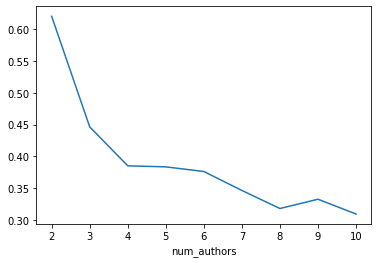

In [8]:
new_df.groupby('num_authors')['train_score'].mean().plot()

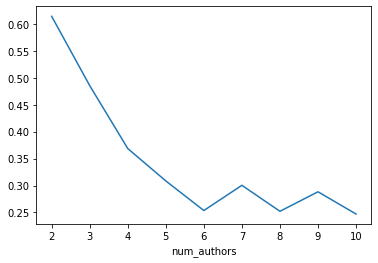

In [9]:
new_df.groupby('num_authors')['test_score'].mean().plot()

While it is clear that the accuracy worsens with the increase of the number of classes in every model, the different models still act differently and the average score varies amongst them.

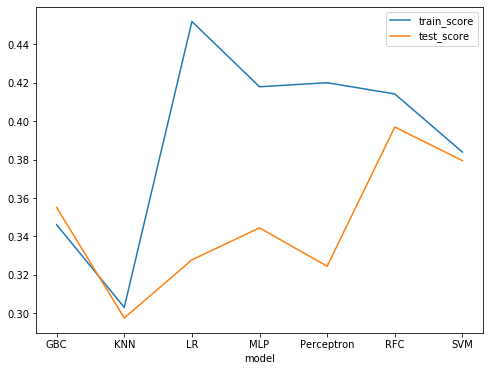

In [62]:
new_df.groupby('model')[['train_score', 'test_score']].mean().plot(figsize = (8,6))

Due to the significant difference between train and test score, I will focus on the test score dynamic from now on.

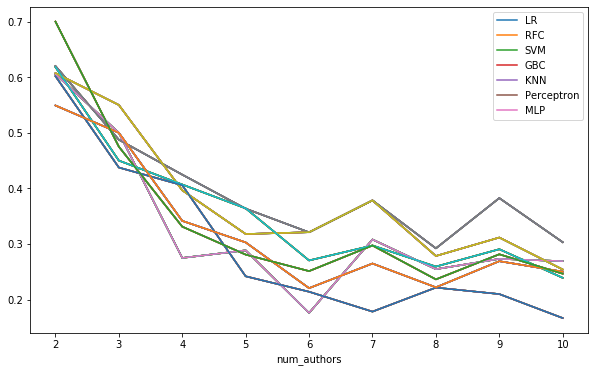

In [120]:
for model in new_df.model:
    ax = new_df[new_df.model == model].groupby('num_authors')['test_score'].mean().plot(figsize = (10,6))
    ax.legend(new_df.model.unique())

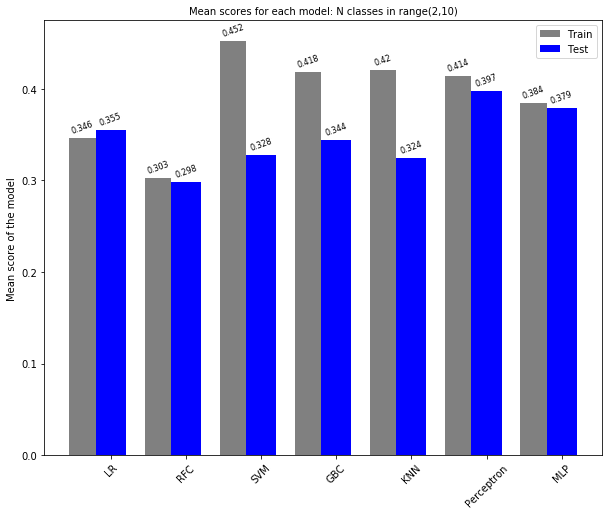

In [56]:
labels = list(new_df.model.unique())
train_means = list(new_df.groupby('model')['train_score'].mean().round(3))
test_means = list(new_df.groupby('model')['test_score'].mean().round(3))

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 8))
rects1 = ax.bar(x - width, train_means,  color = 'grey', label='Train', align = 'edge', width = -0.35)
rects2 = ax.bar(x + width, test_means, color = 'blue', label ='Test', align = 'edge', width = -0.4)

# Adding the title, y-axis and x-axis tick labels
ax.set_title('Mean scores for each model: N classes in range(2,10)', size=10)
ax.set_ylabel('Mean score of the model', size=10)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()
plt.xticks(x, labels, rotation='45', size=10)
ax.tick_params(labelsize  = 10)


def autolabel(rects):
   #Attaching a text label above each bar
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation='20', fontsize=8)

autolabel(rects1)
autolabel(rects2)


plt.show()

The best results on the test set are linked to the use of Neural Networks: Perceptron and Multi-Layer Perceptron, which is probably explained by the ability of Neural Networks to take the previous error into consideration (which probably explains the relatively 'high' score for Gradient Boosting, as the priority in sub-setting the data is given to hard to fit data).

At the same time, the used basic Neural Networks did not demonstrate the full capacity of these algorithms due to the the simple structure and relatively small dataset. It will be corrected in the Iteration 2 by designing more developed architecture and using the bigger dataset.

# Test run on the full dataset

Next I am testing the best found models on on all 40 classes.

In [10]:
fin_lines.head()

,book_author,len_line,neg,neu,pos,compound,objectivity,pos_vs_neg,ADJ,ADV,...,year old,yellow,yesterday,yield,youll,young,young man,young woman,youth,youv
0,Grant Allen,307,0.058,0.908,0.034,-0.3400,0.908,-0.024,5,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Grant Allen,434,0.231,0.669,0.100,-0.9233,0.669,-0.131,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grant Allen,303,0.051,0.949,0.000,-0.4588,0.949,-0.051,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Grant Allen,317,0.039,0.926,0.035,-0.0550,0.926,-0.004,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Grant Allen,499,0.000,0.896,0.104,0.8387,0.896,0.104,6,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
final_comparison = pd.DataFrame()
final_comparison['model'] = ['LR', 'RFC', 'SVM', 'GradientBoostingClassifier','KNN', 'MLPClassifier']

In [12]:
y = fin_lines.pop('book_author')
X = fin_lines

In [13]:
labels = list(y.unique())

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
# standardize the data
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns) 

In [17]:
# First model - Logistical Regression + GridSearch
LR = LogisticRegression()
LR_gs_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                 'C':[0.001,.009,0.01,.09,1,5,10,25],
                'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
               }
print("GridSearching LR...")
LR_grid = GridSearchCV(LR, param_grid = LR_gs_params, n_jobs=-1, cv=3, scoring = 'accuracy')
LR_grid.fit(X_train, y_train)
print('LR done')

GridSearching LR...
LR done


In [18]:
# Second model - Random Forest Classifier
RFC = RandomForestClassifier()
RFC_gs_params = {'n_estimators': [30, 50, 100, 200, 300],
                 'criterion': ['gini', 'mse', 'mae'],
                 'max_depth': [10,15,25,30,50, 75,100],
                 'random_state':[42]
                }
print("GridSearching RFC...")
RFC_grid = GridSearchCV(RFC, param_grid = RFC_gs_params, n_jobs=-1, cv=3, scoring = 'accuracy')
RFC_grid.fit(X_train, y_train)
print('RFC done')

GridSearching RFC...


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RFC done


In [19]:
# Third model - Support Vector Machine Classifier
svm_cl = svm.SVC()
svm_params = {'C': [0.1,1, 10, 100], 
                  'gamma': [0.1, 1, 10, 50, 100],
                  'kernel': ['rbf', 'sigmoid'],
                  'decision_function_shape': ['ovo', 'ovr']
                 }
print("GridSearching SVM...")
svm_grid = GridSearchCV(svm_cl, param_grid = svm_params, n_jobs=-1, cv=3, scoring = 'accuracy')
svm_grid.fit(X_train, y_train)
print('SVM done')

GridSearching SVM...


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


SVM done


In [22]:
# Fourth model - GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_params = {'loss': ['deviance', 'exponential'],
             'learning_rate': [0.1, 0.2, 0.3, 0.5, 1],
             'n_estimators': [10, 25, 50],
             'criterion': ['friedman_mse', 'mse', 'mae', 'gini']
             }
print("GridSearching GB...")
gb_grid = GridSearchCV(gb_model, param_grid = gb_params, n_jobs=-1, cv=3, scoring = 'accuracy')
gb_grid.fit(X_train, y_train)
print('GB done')

GridSearching GB...
GB done


In [23]:
# Fifth model - k-Nearest Neighbours Classifier
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [5, 9, 15, 25, 40],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}
print("GridSearching KNN...")
knn_grid = GridSearchCV(knn,  param_grid = knn_params, n_jobs=-1, cv=3, scoring = 'accuracy')
knn_grid.fit(X_train, y_train)
print('KNN done')

GridSearching KNN...
KNN done


In [24]:
# # Sixth model -  Perceptron - showed the worst score, so it will be skipped here

In [25]:
# Seventh model - MLP Classifier

clf = MLPClassifier(batch_size= 'auto',learning_rate_init=0.001,max_iter=500, momentum=0.9,
                        nesterovs_momentum=True, shuffle=True, tol=10**(-4))
clf_params = {'solver': ['lbfgs', 'sgd', 'adam'],
                    'hidden_layer_sizes': [(40,40,10),(40, 20, 10), (50, 30, 10)],
                    'activation': ['identity', 'logistic', 'tanh', 'relu'],
#                     'alpha': np.logspace(-5, 3, 5), 
                    'early_stopping': [True, False],
#                     'learning_rate':['constant', 'invscaling', 'adaptive']
                 }
print("GridSearching MLP...")
clf_grid = GridSearchCV(clf, param_grid = clf_params, n_jobs =-2, cv=3, scoring = 'accuracy')
clf_grid.fit(X_train, y_train)

GridSearching MLP...


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-2,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         '

In [29]:
# Saving the model parameters, accuracy score, precision, recall and F-1 score into a dataframe

final_comparison['params'] = [LR_grid.best_estimator_,
                            RFC_grid.best_estimator_,
                            svm_grid.best_estimator_,
                            gb_grid.best_estimator_,
                            knn_grid.best_estimator_, 
                            clf_grid.best_estimator_]

In [32]:
final_comparison['cv_score_train_score'] = [cross_val_score(LR_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(RFC_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(svm_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(gb_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(knn_grid.best_estimator_, X_train, y_train).mean(),
                                      cross_val_score(clf_grid.best_estimator_, X_train, y_train).mean()]
final_comparison['cv_score_test_score'] = [cross_val_score(LR_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(RFC_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(svm_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(gb_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(knn_grid.best_estimator_, X_test, y_test).mean(),
                                      cross_val_score(clf_grid.best_estimator_, X_test, y_test).mean()]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [36]:
final_comparison['accuracy_train_score'] = [accuracy_score(LR_grid.best_estimator_.predict(X_train), y_train),
                                      accuracy_score(RFC_grid.best_estimator_.predict(X_train), y_train),
                                      accuracy_score(svm_grid.best_estimator_.predict(X_train), y_train),
                                      accuracy_score(gb_grid.best_estimator_.predict(X_train), y_train),
                                      accuracy_score(knn_grid.best_estimator_.predict(X_train), y_train),
                                      accuracy_score(clf_grid.best_estimator_.predict(X_train), y_train)]
final_comparison['accuracy_test_score'] = [accuracy_score(LR_grid.best_estimator_.predict(X_test), y_test),
                                      accuracy_score(RFC_grid.best_estimator_.predict(X_test), y_test),
                                      accuracy_score(svm_grid.best_estimator_.predict(X_test), y_test),
                                      accuracy_score(gb_grid.best_estimator_.predict(X_test), y_test),
                                      accuracy_score(knn_grid.best_estimator_.predict(X_test), y_test),
                                      accuracy_score(clf_grid.best_estimator_.predict(X_test), y_test)]

In [38]:
final_comparison['precision'] = [precision_score(y_test, LR_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 precision_score(y_test, RFC_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 precision_score(y_test, svm_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 precision_score(y_test, gb_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 precision_score(y_test, knn_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 precision_score(y_test, clf_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro')]
final_comparison['recall'] = [recall_score(y_test, LR_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 recall_score(y_test, RFC_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 recall_score(y_test, svm_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 recall_score(y_test, gb_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 recall_score(y_test, knn_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro'),
                                 recall_score(y_test, clf_grid.best_estimator_.predict(X_test), labels = labels, average = 'macro')]
final_comparison['f1_score'] = [(2/(1/final_comparison['recall'][i]+1/final_comparison['precision'][i])) for i in range(len(final_comparison))]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
final_comparison

,model,params,cv_score_train_score,cv_score_test_score,accuracy_train_score,accuracy_test_score,precision,recall,f1_score
0,LR,"LogisticRegression(C=0.001, class_weight=None,...",0.278462,0.158142,0.999534,0.284091,0.284827,0.291233,0.287994
1,RFC,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.239734,0.159108,1.000000,0.250947,0.247370,0.258869,0.252989
2,SVM,"SVC(C=0.1, break_ties=False, cache_size=200, c...",0.128735,0.109863,0.088619,0.136364,0.159120,0.139667,0.148760
3,GradientBoostingClassifier,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.165117,0.087132,0.989739,0.171402,0.177084,0.175282,0.176179
4,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.151594,0.069118,1.000000,0.186553,0.362732,0.193739,0.252575
5,MLPClassifier,"MLPClassifier(activation='identity', alpha=0.0...",0.179585,0.090901,1.000000,0.202652,0.200849,0.208713,0.204705


In [72]:
final_comparison = pd.read_csv('/Users/eiwi/GA_stuff/GA_lessons/DSI11-lessons/projects/project-capstone/For GitHub/Iteration 1_ 40 authors/Comparison/final_comparison.csv')

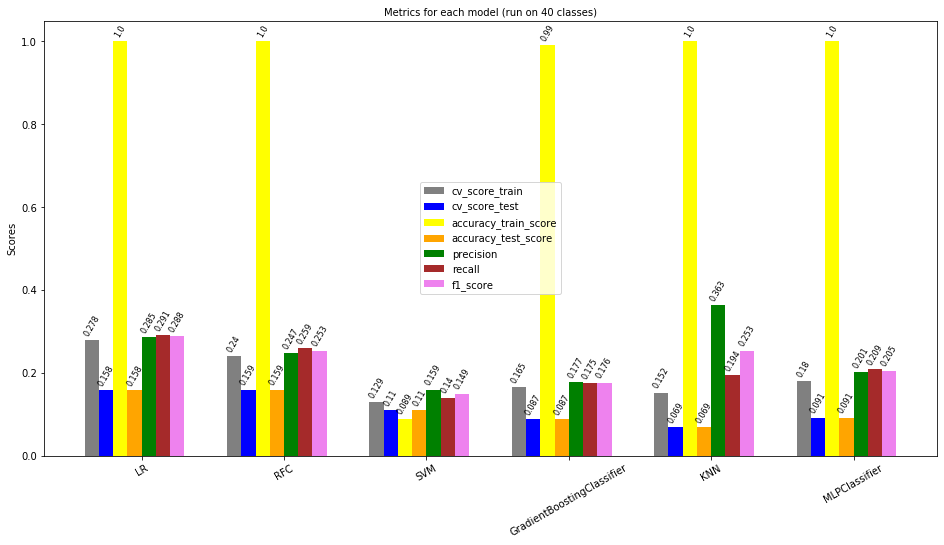

In [119]:
labels = list(final_comparison.model.unique())

cv_score_train_means = list(final_comparison['cv_score_train_score'].round(3))
cv_score_test_means = list(final_comparison['cv_score_test_score'].round(3))
accuracy_train_score_means = list(final_comparison['accuracy_train_score'].round(3))
accuracy_test_score_means = list(final_comparison['cv_score_test_score'].round(3))
precision = list(final_comparison['precision'].round(3))
recall = list(final_comparison['recall'].round(3))
f1_score = list(final_comparison['f1_score'].round(3))


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))

rects1 = ax.bar(x - 2*width, cv_score_train_means,  color = 'grey', label='cv_score_train', align = 'edge', width = 0.1)
rects2 = ax.bar(x - 1.5*width, cv_score_test_means, color = 'blue', label ='cv_score_test', align = 'edge', width = 0.1)
rects3 = ax.bar(x - width, accuracy_train_score_means,  color = 'yellow', label='accuracy_train_score', align = 'edge', width = 0.1)
rects4 = ax.bar(x - 0.5*width, accuracy_test_score_means, color = 'orange', label ='accuracy_test_score', align = 'edge', width = 0.1)
rects5 = ax.bar(x, precision,  color = 'green', label='precision', align = 'edge', width = 0.1)
rects6 = ax.bar(x + 0.5*width, recall, color = 'brown', label ='recall', align = 'edge', width = 0.1)
rects7 = ax.bar(x + width, f1_score, color = 'violet', label ='f1_score', align = 'edge',width = 0.1)


# Adding the title, y-axis and x-axis tick labels
ax.set_title('Metrics for each model (run on 40 classes)', size=10)
ax.set_ylabel('Scores', size=10)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(loc = 'center')
plt.xticks(x, labels, rotation='30', size=10)
ax.tick_params(labelsize  = 10)


def autolabel(rects):
   #Attaching a text label above each bar
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation='60', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)
autolabel(rects7)

plt.show()

The received results once again prove that the higher number of classes (40 authors) continue to worsen the accuracy of the models.

In order to understand what makes the algorithm confuse authors (authors) I will further explore confusion matrices and feature importance.

In [40]:
# Function for confusion matrix transformation to DataFrame
# Code from https://gist.github.com/nickynicolson/202fe765c99af49acb20ea9f77b6255e

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]= np.round_(cm[i,j], decimals=3)
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

### Logistic Regression

In [42]:
# Confusion matrix:

cm2df((confusion_matrix(y_test, LR_grid.best_estimator_.predict(X_test),LR_grid.best_estimator_.classes_, normalize='true')), LR_grid.best_estimator_.classes_)

,Agatha Christie,Anna Katharine Green,Anthony Berkeley,Arthur B.Reeve,Arthur Conan Doyle,Charlotte Armstrong,Dashiell Hammett,Dorothy L.Sayers,Edgar Allan Poe,Edgar Jepson,...,Melville Davisson Post,Michael Connelly,Mignon G.Eberhart,Ngaio Marsh,Nicholas Blake,Rex Stout,Richard Connell,Robert William Chambers,Sidney Sheldon,William Hope Hodgson
Agatha Christie,0.083,0.000,0.000,0.083,0.000,0.042,0.042,0.000,0.083,0.042,...,0.000,0.000,0.000,0.000,0.042,0.042,0.000,0.000,0.000,0.000
Anna Katharine Green,0.000,0.154,0.000,0.000,0.038,0.000,0.000,0.000,0.038,0.000,...,0.038,0.038,0.000,0.000,0.038,0.000,0.000,0.000,0.000,0.038
Anthony Berkeley,0.062,0.094,0.250,0.062,0.000,0.000,0.000,0.062,0.094,0.000,...,0.000,0.000,0.031,0.000,0.000,0.000,0.000,0.000,0.031,0.000
Arthur B.Reeve,0.000,0.120,0.000,0.160,0.000,0.000,0.000,0.040,0.080,0.040,...,0.000,0.000,0.080,0.000,0.040,0.000,0.040,0.000,0.000,0.000
Arthur Conan Doyle,0.042,0.000,0.000,0.083,0.083,0.000,0.000,0.042,0.042,0.000,...,0.042,0.042,0.000,0.000,0.042,0.083,0.000,0.042,0.000,0.000
Charlotte Armstrong,0.071,0.000,0.000,0.036,0.000,0.143,0.036,0.071,0.000,0.000,...,0.036,0.000,0.143,0.000,0.000,0.071,0.036,0.071,0.071,0.000
Dashiell Hammett,0.000,0.033,0.000,0.033,0.033,0.000,0.167,0.000,0.000,0.000,...,0.033,0.000,0.033,0.033,0.067,0.033,0.033,0.000,0.000,0.000
Dorothy L.Sayers,0.043,0.000,0.000,0.000,0.000,0.043,0.000,0.304,0.000,0.043,...,0.043,0.000,0.000,0.000,0.000,0.130,0.000,0.000,0.087,0.043
Edgar Allan Poe,0.000,0.074,0.000,0.000,0.111,0.000,0.037,0.000,0.259,0.000,...,0.074,0.000,0.000,0.000,0.000,0.074,0.000,0.000,0.000,0.000
Edgar Jepson,0.000,0.045,0.000,0.045,0.000,0.000,0.000,0.000,0.045,0.455,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


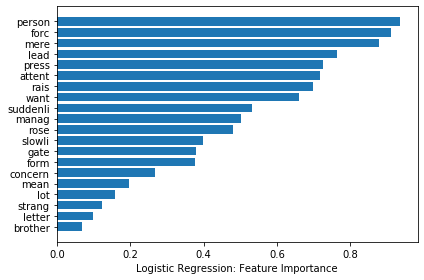

In [102]:
# Feature importance
feature_importance = abs(LR_grid.best_estimator_.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[:20]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
featax.set_xlabel('Logistic Regression: Feature Importance')

plt.tight_layout()   
plt.show()

In [44]:
# Random Forest Classifier

# Confusion matrix:

cm2df((confusion_matrix(y_test, RFC_grid.best_estimator_.predict(X_test),RFC_grid.best_estimator_.classes_, normalize='true')), RFC_grid.best_estimator_.classes_)

,Agatha Christie,Anna Katharine Green,Anthony Berkeley,Arthur B.Reeve,Arthur Conan Doyle,Charlotte Armstrong,Dashiell Hammett,Dorothy L.Sayers,Edgar Allan Poe,Edgar Jepson,...,Melville Davisson Post,Michael Connelly,Mignon G.Eberhart,Ngaio Marsh,Nicholas Blake,Rex Stout,Richard Connell,Robert William Chambers,Sidney Sheldon,William Hope Hodgson
Agatha Christie,0.000,0.000,0.000,0.000,0.000,0.042,0.000,0.000,0.000,0.083,...,0.000,0.042,0.000,0.000,0.042,0.000,0.083,0.000,0.042,0.083
Anna Katharine Green,0.000,0.000,0.038,0.000,0.038,0.000,0.000,0.000,0.000,0.115,...,0.000,0.000,0.038,0.000,0.000,0.038,0.000,0.000,0.000,0.000
Anthony Berkeley,0.000,0.125,0.125,0.031,0.000,0.000,0.000,0.031,0.031,0.000,...,0.000,0.031,0.000,0.000,0.031,0.031,0.062,0.000,0.031,0.000
Arthur B.Reeve,0.040,0.040,0.000,0.200,0.000,0.000,0.000,0.040,0.040,0.040,...,0.040,0.000,0.000,0.000,0.000,0.000,0.040,0.040,0.040,0.000
Arthur Conan Doyle,0.042,0.042,0.000,0.000,0.125,0.000,0.042,0.083,0.000,0.000,...,0.042,0.042,0.042,0.000,0.000,0.000,0.000,0.000,0.042,0.000
Charlotte Armstrong,0.107,0.000,0.000,0.000,0.000,0.071,0.000,0.071,0.000,0.036,...,0.000,0.036,0.036,0.000,0.036,0.000,0.000,0.000,0.071,0.000
Dashiell Hammett,0.033,0.000,0.000,0.000,0.033,0.000,0.167,0.000,0.000,0.033,...,0.033,0.000,0.033,0.000,0.033,0.000,0.033,0.000,0.067,0.000
Dorothy L.Sayers,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.348,0.000,0.043,...,0.000,0.043,0.000,0.000,0.000,0.000,0.043,0.000,0.043,0.043
Edgar Allan Poe,0.000,0.037,0.000,0.000,0.037,0.000,0.000,0.037,0.148,0.037,...,0.037,0.074,0.000,0.000,0.000,0.037,0.000,0.000,0.000,0.037
Edgar Jepson,0.000,0.045,0.000,0.000,0.000,0.000,0.045,0.000,0.045,0.409,...,0.045,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.091


Text(0.5, 1.0, 'Logistic Regression: Feature Importance')

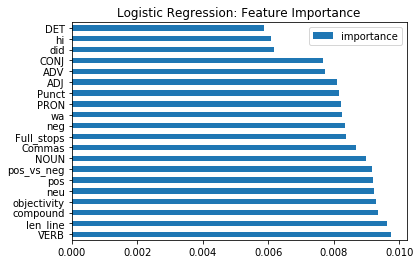

In [45]:
# Feature importance

feature_importances = pd.DataFrame(RFC_grid.best_estimator_.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(20).plot(kind = 'barh')
plt.title('Logistic Regression: Feature Importance')

In [46]:
# Support Vector Machine Classifier

# Confusion matrix:

cm2df((confusion_matrix(y_test, clf_grid.best_estimator_.predict(X_test),clf_grid.best_estimator_.classes_, normalize='true')), clf_grid.best_estimator_.classes_)

,Agatha Christie,Anna Katharine Green,Anthony Berkeley,Arthur B.Reeve,Arthur Conan Doyle,Charlotte Armstrong,Dashiell Hammett,Dorothy L.Sayers,Edgar Allan Poe,Edgar Jepson,...,Melville Davisson Post,Michael Connelly,Mignon G.Eberhart,Ngaio Marsh,Nicholas Blake,Rex Stout,Richard Connell,Robert William Chambers,Sidney Sheldon,William Hope Hodgson
Agatha Christie,0.083,0.083,0.083,0.000,0.000,0.042,0.042,0.000,0.083,0.000,...,0.000,0.042,0.042,0.000,0.125,0.000,0.042,0.083,0.000,0.042
Anna Katharine Green,0.000,0.000,0.038,0.000,0.038,0.000,0.038,0.000,0.038,0.077,...,0.038,0.000,0.077,0.000,0.000,0.038,0.000,0.038,0.038,0.000
Anthony Berkeley,0.094,0.031,0.188,0.000,0.000,0.000,0.031,0.000,0.062,0.031,...,0.000,0.000,0.031,0.031,0.000,0.031,0.000,0.062,0.000,0.000
Arthur B.Reeve,0.040,0.040,0.000,0.080,0.000,0.040,0.040,0.000,0.080,0.000,...,0.000,0.000,0.000,0.000,0.040,0.000,0.000,0.000,0.040,0.040
Arthur Conan Doyle,0.083,0.042,0.042,0.083,0.042,0.042,0.000,0.000,0.000,0.000,...,0.042,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Charlotte Armstrong,0.036,0.036,0.000,0.036,0.000,0.179,0.000,0.000,0.036,0.036,...,0.000,0.036,0.000,0.071,0.000,0.000,0.000,0.071,0.036,0.000
Dashiell Hammett,0.033,0.000,0.067,0.000,0.033,0.033,0.233,0.033,0.033,0.000,...,0.000,0.000,0.033,0.033,0.100,0.000,0.000,0.000,0.033,0.000
Dorothy L.Sayers,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.348,0.130,0.000,...,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Edgar Allan Poe,0.000,0.074,0.000,0.000,0.000,0.037,0.037,0.000,0.037,0.000,...,0.000,0.037,0.000,0.074,0.000,0.074,0.037,0.037,0.000,0.000
Edgar Jepson,0.000,0.045,0.091,0.045,0.000,0.045,0.045,0.000,0.000,0.182,...,0.000,0.045,0.045,0.045,0.000,0.045,0.000,0.045,0.000,0.045


In [47]:
# Feature importance is not available as the best estimator has sigmoid kernel (not linear)


In [49]:
# GradientBoost Classifier

# Confusion matrix:

cm2df((confusion_matrix(y_test, gb_grid.best_estimator_.predict(X_test),gb_grid.best_estimator_.classes_, normalize='true')), gb_grid.best_estimator_.classes_)

,Agatha Christie,Anna Katharine Green,Anthony Berkeley,Arthur B.Reeve,Arthur Conan Doyle,Charlotte Armstrong,Dashiell Hammett,Dorothy L.Sayers,Edgar Allan Poe,Edgar Jepson,...,Melville Davisson Post,Michael Connelly,Mignon G.Eberhart,Ngaio Marsh,Nicholas Blake,Rex Stout,Richard Connell,Robert William Chambers,Sidney Sheldon,William Hope Hodgson
Agatha Christie,0.000,0.042,0.000,0.000,0.000,0.042,0.000,0.000,0.125,0.000,...,0.042,0.000,0.042,0.000,0.083,0.000,0.000,0.000,0.000,0.000
Anna Katharine Green,0.000,0.000,0.000,0.000,0.077,0.000,0.000,0.038,0.077,0.000,...,0.077,0.000,0.000,0.000,0.038,0.000,0.038,0.000,0.000,0.000
Anthony Berkeley,0.031,0.031,0.188,0.031,0.000,0.000,0.000,0.031,0.031,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.062,0.031,0.000
Arthur B.Reeve,0.000,0.080,0.000,0.040,0.000,0.040,0.040,0.040,0.000,0.000,...,0.000,0.040,0.000,0.000,0.080,0.000,0.000,0.040,0.000,0.040
Arthur Conan Doyle,0.042,0.000,0.000,0.000,0.042,0.042,0.042,0.042,0.042,0.000,...,0.042,0.042,0.000,0.000,0.042,0.083,0.042,0.042,0.000,0.000
Charlotte Armstrong,0.071,0.000,0.036,0.000,0.000,0.036,0.000,0.000,0.000,0.036,...,0.000,0.036,0.179,0.071,0.036,0.000,0.000,0.036,0.036,0.036
Dashiell Hammett,0.000,0.000,0.000,0.067,0.033,0.033,0.100,0.000,0.000,0.000,...,0.000,0.000,0.033,0.000,0.033,0.033,0.000,0.033,0.033,0.000
Dorothy L.Sayers,0.000,0.000,0.043,0.000,0.000,0.043,0.043,0.261,0.000,0.043,...,0.000,0.000,0.000,0.000,0.043,0.000,0.043,0.043,0.087,0.087
Edgar Allan Poe,0.037,0.000,0.000,0.000,0.000,0.000,0.074,0.037,0.000,0.000,...,0.037,0.000,0.037,0.074,0.000,0.000,0.000,0.037,0.000,0.037
Edgar Jepson,0.000,0.091,0.000,0.045,0.000,0.000,0.000,0.000,0.045,0.227,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.045,0.000


Text(0.5, 1.0, 'Gradient Boosting: Feature Importance')

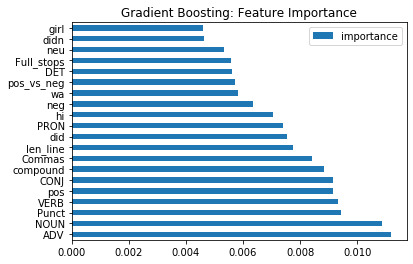

In [56]:
# Feature Importance

feature_importances = pd.DataFrame(gb_grid.best_estimator_.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(20).plot(kind = 'barh')
plt.title('Gradient Boosting: Feature Importance')

In [51]:
# K-Nearest Neighbours

# Confusion matrix:

cm2df((confusion_matrix(y_test, knn_grid.best_estimator_.predict(X_test),knn_grid.best_estimator_.classes_, normalize='true')), knn_grid.best_estimator_.classes_)

,Agatha Christie,Anna Katharine Green,Anthony Berkeley,Arthur B.Reeve,Arthur Conan Doyle,Charlotte Armstrong,Dashiell Hammett,Dorothy L.Sayers,Edgar Allan Poe,Edgar Jepson,...,Melville Davisson Post,Michael Connelly,Mignon G.Eberhart,Ngaio Marsh,Nicholas Blake,Rex Stout,Richard Connell,Robert William Chambers,Sidney Sheldon,William Hope Hodgson
Agatha Christie,0.167,0.000,0.000,0.000,0.083,0.000,0.0,0.000,0.000,0.042,...,0.000,0.042,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.042
Anna Katharine Green,0.154,0.000,0.077,0.000,0.115,0.000,0.0,0.000,0.000,0.038,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.038,0.077,0.038
Anthony Berkeley,0.125,0.000,0.188,0.000,0.031,0.000,0.0,0.000,0.031,0.000,...,0.031,0.062,0.000,0.000,0.000,0.0,0.000,0.000,0.031,0.000
Arthur B.Reeve,0.080,0.000,0.000,0.040,0.120,0.000,0.0,0.000,0.000,0.040,...,0.000,0.000,0.000,0.040,0.000,0.0,0.040,0.000,0.040,0.000
Arthur Conan Doyle,0.125,0.083,0.042,0.000,0.250,0.000,0.0,0.000,0.000,0.000,...,0.000,0.042,0.000,0.000,0.000,0.0,0.000,0.042,0.000,0.000
Charlotte Armstrong,0.143,0.000,0.000,0.000,0.071,0.071,0.0,0.000,0.000,0.036,...,0.000,0.071,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
Dashiell Hammett,0.100,0.000,0.000,0.100,0.000,0.033,0.1,0.000,0.000,0.000,...,0.000,0.000,0.067,0.033,0.000,0.0,0.000,0.033,0.033,0.000
Dorothy L.Sayers,0.087,0.000,0.043,0.000,0.043,0.000,0.0,0.261,0.000,0.000,...,0.000,0.000,0.000,0.043,0.000,0.0,0.000,0.000,0.043,0.000
Edgar Allan Poe,0.074,0.000,0.074,0.000,0.074,0.000,0.0,0.000,0.000,0.000,...,0.037,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.037
Edgar Jepson,0.136,0.000,0.000,0.000,0.091,0.000,0.0,0.000,0.000,0.227,...,0.045,0.000,0.045,0.000,0.000,0.0,0.000,0.045,0.045,0.000


In [52]:
# Feature Importance is not defined for KNN

In [57]:
# Multi-Layer Perceptron

# Confusion matrix:

cm2df((confusion_matrix(y_test, clf_grid.best_estimator_.predict(X_test),clf_grid.best_estimator_.classes_, normalize='true')), clf_grid.best_estimator_.classes_)

,Agatha Christie,Anna Katharine Green,Anthony Berkeley,Arthur B.Reeve,Arthur Conan Doyle,Charlotte Armstrong,Dashiell Hammett,Dorothy L.Sayers,Edgar Allan Poe,Edgar Jepson,...,Melville Davisson Post,Michael Connelly,Mignon G.Eberhart,Ngaio Marsh,Nicholas Blake,Rex Stout,Richard Connell,Robert William Chambers,Sidney Sheldon,William Hope Hodgson
Agatha Christie,0.083,0.083,0.083,0.000,0.000,0.042,0.042,0.000,0.083,0.000,...,0.000,0.042,0.042,0.000,0.125,0.000,0.042,0.083,0.000,0.042
Anna Katharine Green,0.000,0.000,0.038,0.000,0.038,0.000,0.038,0.000,0.038,0.077,...,0.038,0.000,0.077,0.000,0.000,0.038,0.000,0.038,0.038,0.000
Anthony Berkeley,0.094,0.031,0.188,0.000,0.000,0.000,0.031,0.000,0.062,0.031,...,0.000,0.000,0.031,0.031,0.000,0.031,0.000,0.062,0.000,0.000
Arthur B.Reeve,0.040,0.040,0.000,0.080,0.000,0.040,0.040,0.000,0.080,0.000,...,0.000,0.000,0.000,0.000,0.040,0.000,0.000,0.000,0.040,0.040
Arthur Conan Doyle,0.083,0.042,0.042,0.083,0.042,0.042,0.000,0.000,0.000,0.000,...,0.042,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Charlotte Armstrong,0.036,0.036,0.000,0.036,0.000,0.179,0.000,0.000,0.036,0.036,...,0.000,0.036,0.000,0.071,0.000,0.000,0.000,0.071,0.036,0.000
Dashiell Hammett,0.033,0.000,0.067,0.000,0.033,0.033,0.233,0.033,0.033,0.000,...,0.000,0.000,0.033,0.033,0.100,0.000,0.000,0.000,0.033,0.000
Dorothy L.Sayers,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.348,0.130,0.000,...,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Edgar Allan Poe,0.000,0.074,0.000,0.000,0.000,0.037,0.037,0.000,0.037,0.000,...,0.000,0.037,0.000,0.074,0.000,0.074,0.037,0.037,0.000,0.000
Edgar Jepson,0.000,0.045,0.091,0.045,0.000,0.045,0.045,0.000,0.000,0.182,...,0.000,0.045,0.045,0.045,0.000,0.045,0.000,0.045,0.000,0.045


In [ ]:
# Feature Importance is not defined, as Neural Networks rely on complex co-adaptations of weights during the training 
# phase instead of measuring and comparing quality of splits.

# Conclusion

Based on the confusion matrices, I make a conclusion that almost each author can be confused with any other author, since the models have not picked up the unique features, that would distinguish the authors in the more obvious way. This happened even with the Support Vector Machine, which was designed to separate classes as clear as possible.

Therefore, the in second iteration of this project I am going to implement several changes:

1) Dataset: in order to train the models I will need to collect the bigger dataset with more examples of each authors writing.

2) Models: as the Neural Networks demonstrated relatively promising results, I will further focus my efforts on designing more advanced NN.

3) Features:  it is clear that in order to pick up individual style I need to come up with more features, reflecting on the authors manner of putting the sentences. Also, in the current sample, I have deliberately set some parameters (length of the paragraph, e.g.) to make the selection more homogenious. As we can see, this is an important feature and it would be better not to make such the adjustments.